In [1]:
#Librerías a utilizar
import pandas as pd
import numpy as np

#Graficas 
import graphing
import missingno as ms
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.tree import plot_tree # Función para visualizar el árbol

plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



#Selecionar caracteristicas 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

#Modelos 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

#Metricas
from sklearn.metrics import balanced_accuracy_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

#Transformaciones, separaciones  e imputaciones  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import make_column_transformer

#Funciones
from Funciones import matrix_confusion, fit_and_test_model, CurvaROC, FeatureBest,matrix_confusion_Xgboost


In [2]:
# Lee el archivo de texto prueba que contiene los datos usando pandas
Df_Spaces_test=pd.read_csv('test.csv')

# Lee el archivo de texto entrebamiento que contiene los datos usando pandas
Df_Spaces_train=pd.read_csv('train.csv')

In [3]:
#Descomponer columna para tener una mayor interpretación de los datos
#Column Total
def agregar_Caracteristicas(df):
    #Column PassengerId
    df[['Group','Num_Group']]=df.PassengerId.str.split('_', expand=True)
    #Columna Cabin
    df[['Desk','Num','Side']]=df.Cabin.str.split('/', expand=True)

    #Eliminar las columnas Cabin y Name
    df.drop(['Cabin','Name'], axis=1, inplace=True)

    
    #Cambiar el tipo de columnas Número de grupo
    df['Num_Group'] = df['Num_Group'].astype('int64')
    df['CryoSleep'] = df['CryoSleep'].astype('object')


agregar_Caracteristicas(Df_Spaces_train)
agregar_Caracteristicas(Df_Spaces_test)

# 1. Visualización de los  datos

In [4]:
#Cantidad de valores perdidos en el dataframe de entrenamiento
total_cells_train=np.product(Df_Spaces_train.shape) #El numero de total datos en el dataframe
total_missing_train=Df_Spaces_train.isnull().sum().sum() # se obtiene el número de valores perdidos 

percent_missing_train = (total_missing_train/total_cells_train) * 100 # Se obtiene el porcentaje de valores perdidos

print('Valores perdidos en datos de entrenamiento {}'.format(percent_missing_train)) # Se imprime el porcentaje de valores perdidos en dataframe de entrenamiento 

#cantidad de valores perdidos en el dataframe de prueba 
total_cells_test=np.product(Df_Spaces_test.shape) #El numero total de datos en el dataframe
total_missing_test=Df_Spaces_test.isnull().sum().sum()   # se obtiene el número de valores perdidos 

percent_missing_test = (total_missing_test/total_cells_test) * 100 #Se obtiene el porcentaje de valores perdidos

print('Valores perdidos en datos de prueba {}'.format((percent_missing_test))) # Se imprime el porcentaje de valores perdidos en dataframe de prueba 

Valores perdidos en datos de entrenamiento 1.7065793302251304
Valores perdidos en datos de prueba 1.7871755903670798


Los valores perdidos en el dataframe de entrenamiento y prueba esta alrededor de 2%, Pensaríamos que si eliminamos los valores perdidos no afectan a mucha información en el dataframe, esa conclución es muy temprana, hay que fijarnos si
los valores están de forma aleatoria o no en el dataframe de prueba y de entrenamiento.

<AxesSubplot: >

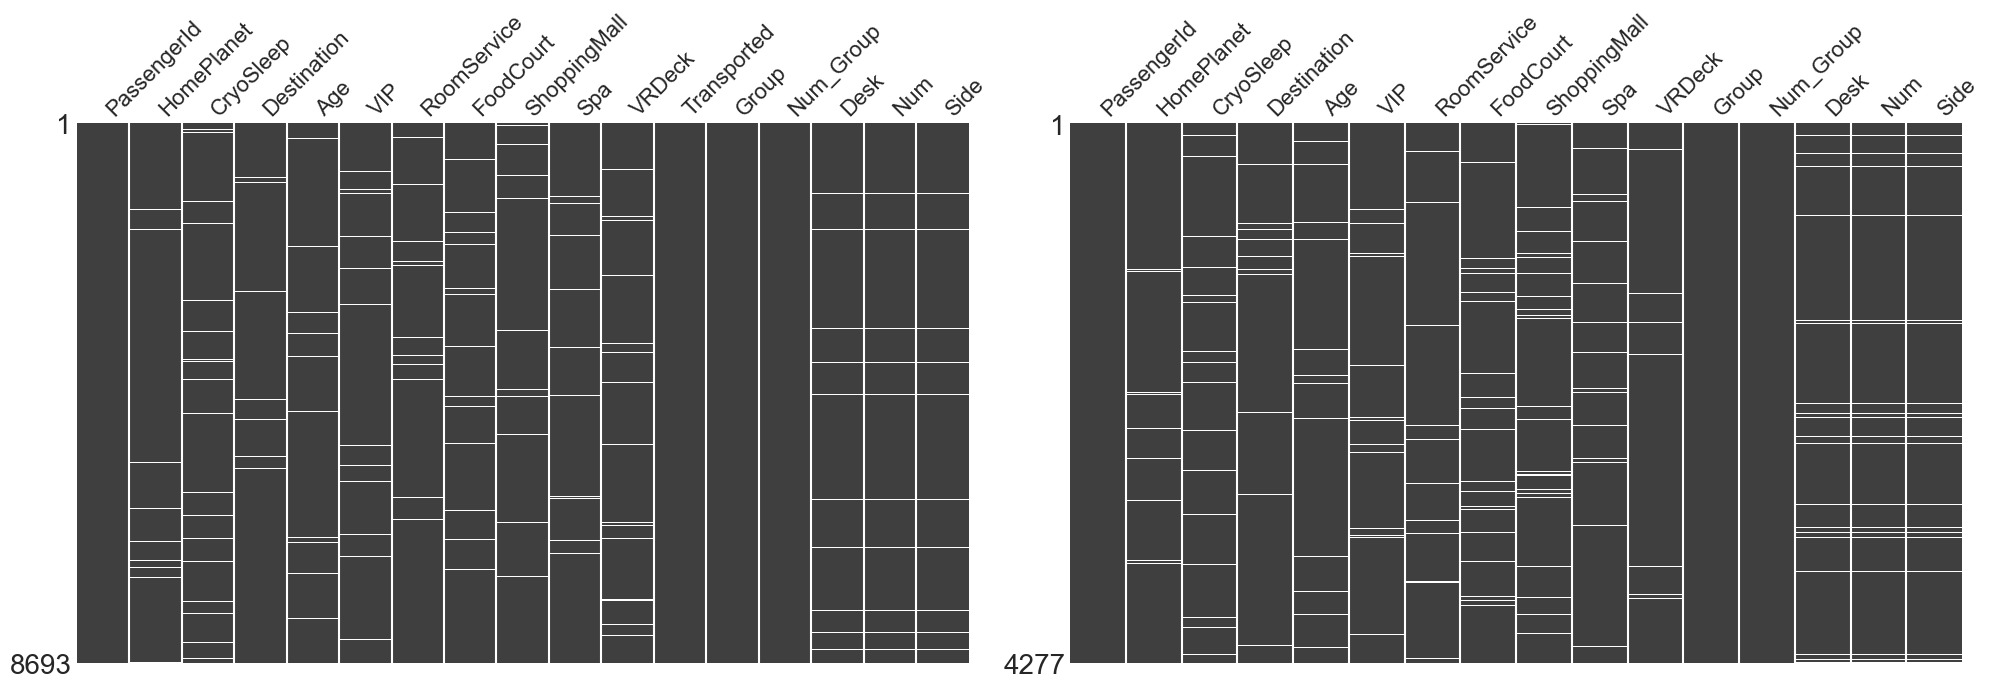

In [126]:
#Visualizar los datos faltantes 
fig, ax=plt.subplots(1,2, figsize=(20,7)) # Una divición para colocar las graficas
ms.matrix(Df_Spaces_train, ax=ax[0], sparkline=False) # Matriz con valores faltantes de entrenamiento
ms.matrix(Df_Spaces_test, ax=ax[1], sparkline=False)  # Matriz con valores faltantes de Prueba

En las gráficas anteriores se puede ver que los valores perdidos están de forma aleatoria en el dataframe, y eliminarlos estaríamos eliminando muchos datos e información valiosa. La cantidad de datos en el dataframe de entrenamiento es dos veces mayor que el de prueba, siendo la cantidad de valores perdidos mayor en el dataframe de prueba.

<AxesSubplot: >

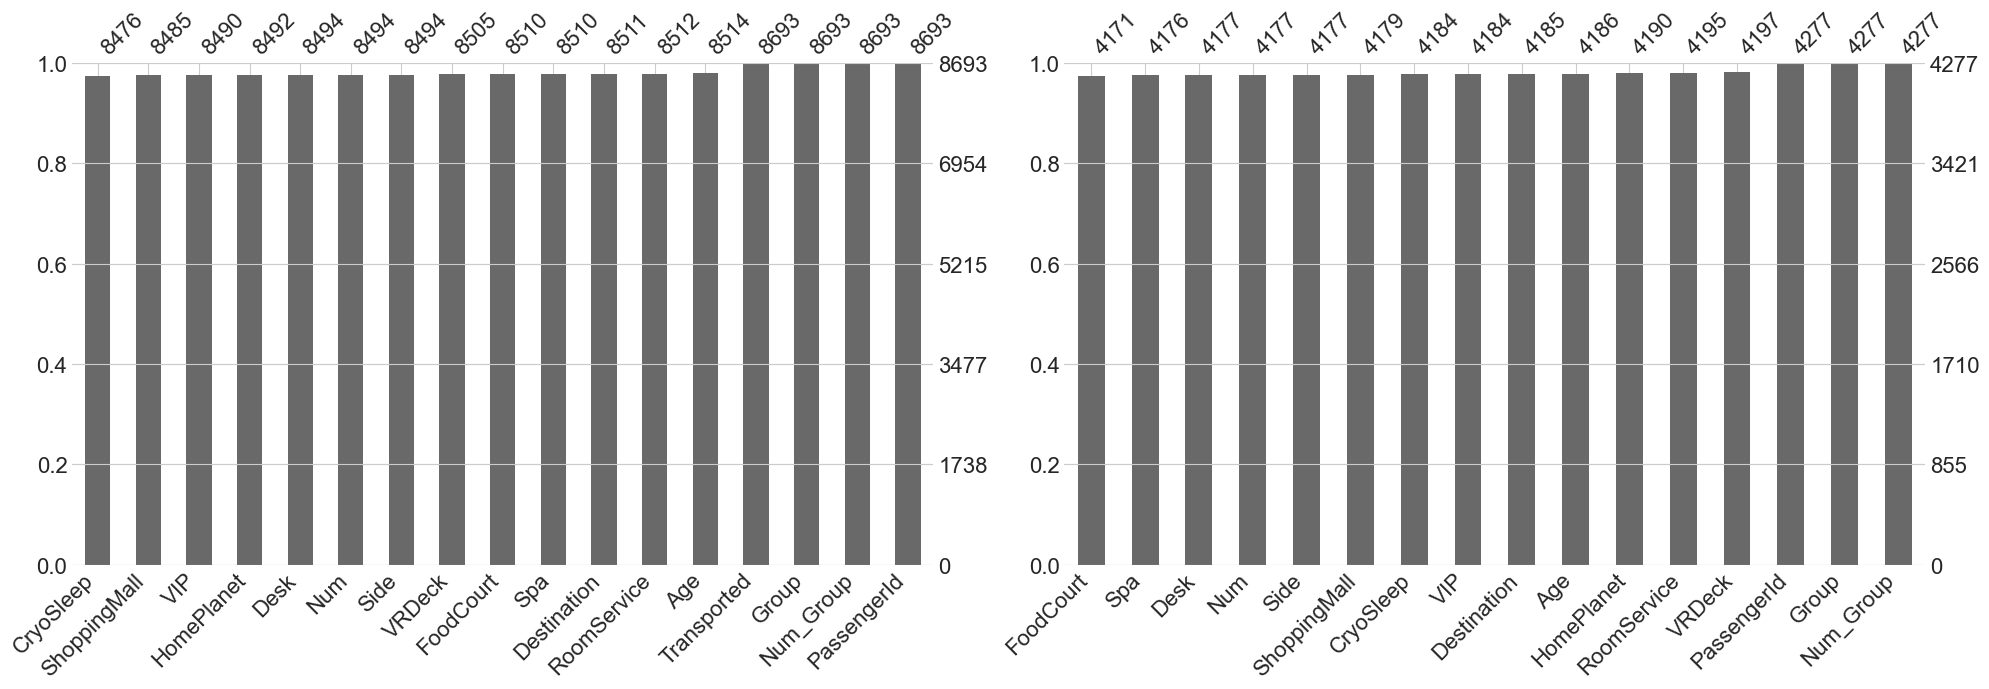

In [127]:
#Visualizar la proporción de valores perdidos
fig, ax=plt.subplots(1,2,figsize=(20,7))
ms.bar(Df_Spaces_train, sort='ascending', ax=ax[0])
ms.bar(Df_Spaces_test,sort='ascending', ax=ax[1])

En las grafícas anteriores se muestra la cantidad de valores que hay por columnas, siendo la columnas con menor datos aquellas que tienen mayor datos faltantes, la graficas anteriores se encuentran ordenada de menor a mayor, siendo CryoSleep la columna con mayor datos faltantes para dataframe de entrenamiento, y foodCourt la columna con mayor datos faltantes para el dataframe de prueba.

<AxesSubplot: >

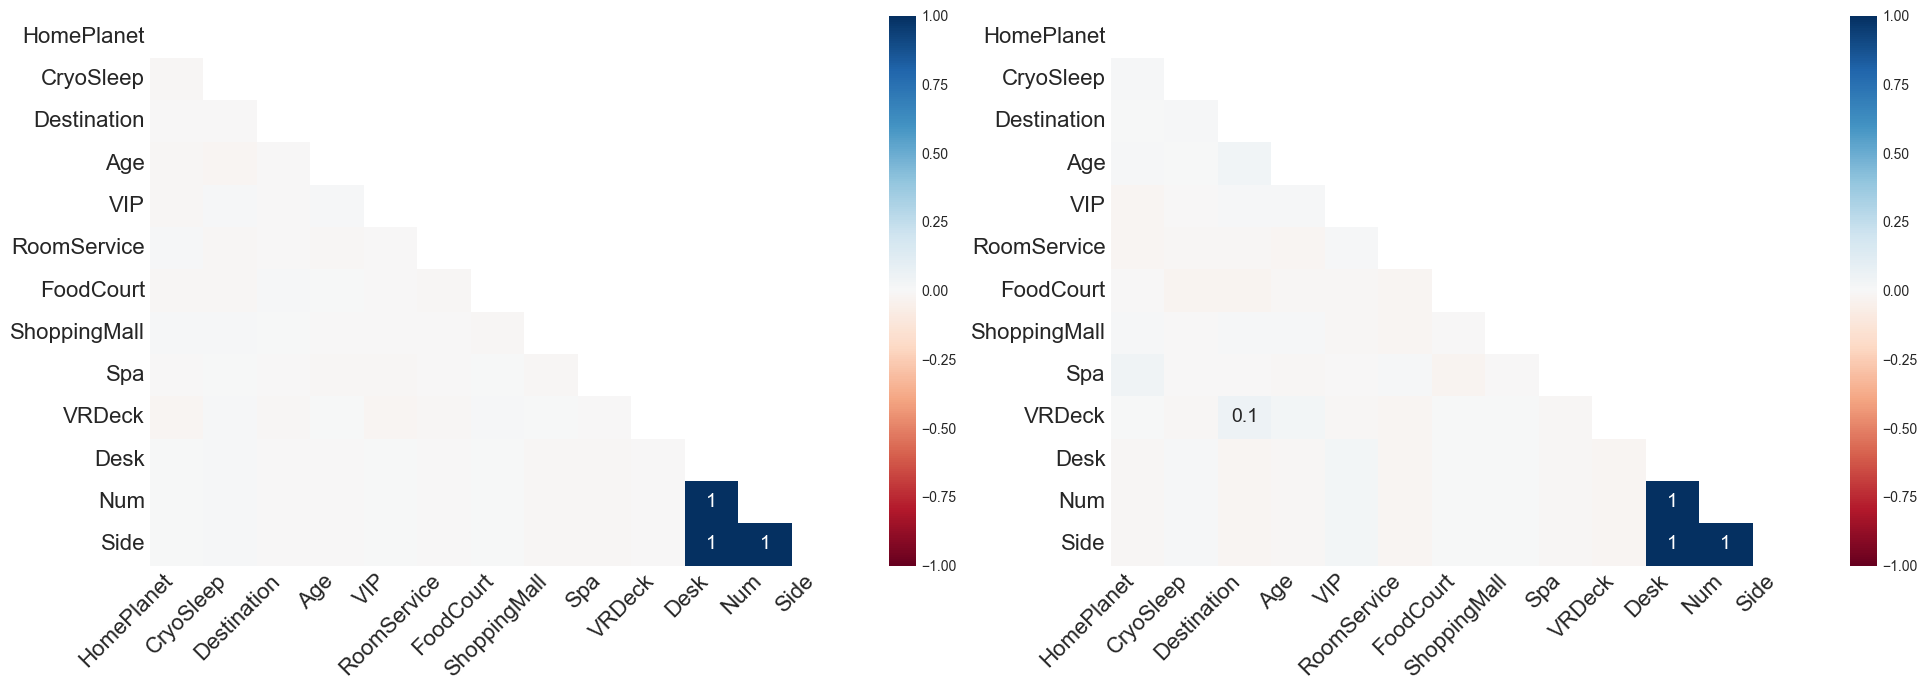

In [128]:
#Visualizar correlaciones de nulalidad entre las diferentes columnas.
fig, ax=plt.subplots(1,2,figsize=(20,7))
ms.heatmap(Df_Spaces_train, ax=ax[0])
ms.heatmap(Df_Spaces_test, ax=ax[1])

En las graficas anterior se puede observar que no hay correlación de nulalidad entre las columnas, de esto se puede afirmar la aleatoriedad de los datos faltante, en los distintos dataframe.

Se logra apreciar una baja correlación de nulalidad de Age y VRDeck

Nota: La nulalidad que se logra apreciar es debido a la columnas(Cabin) que se dividio, que es de esperarse que sus columnas tenga una alta correlación.

<AxesSubplot: >

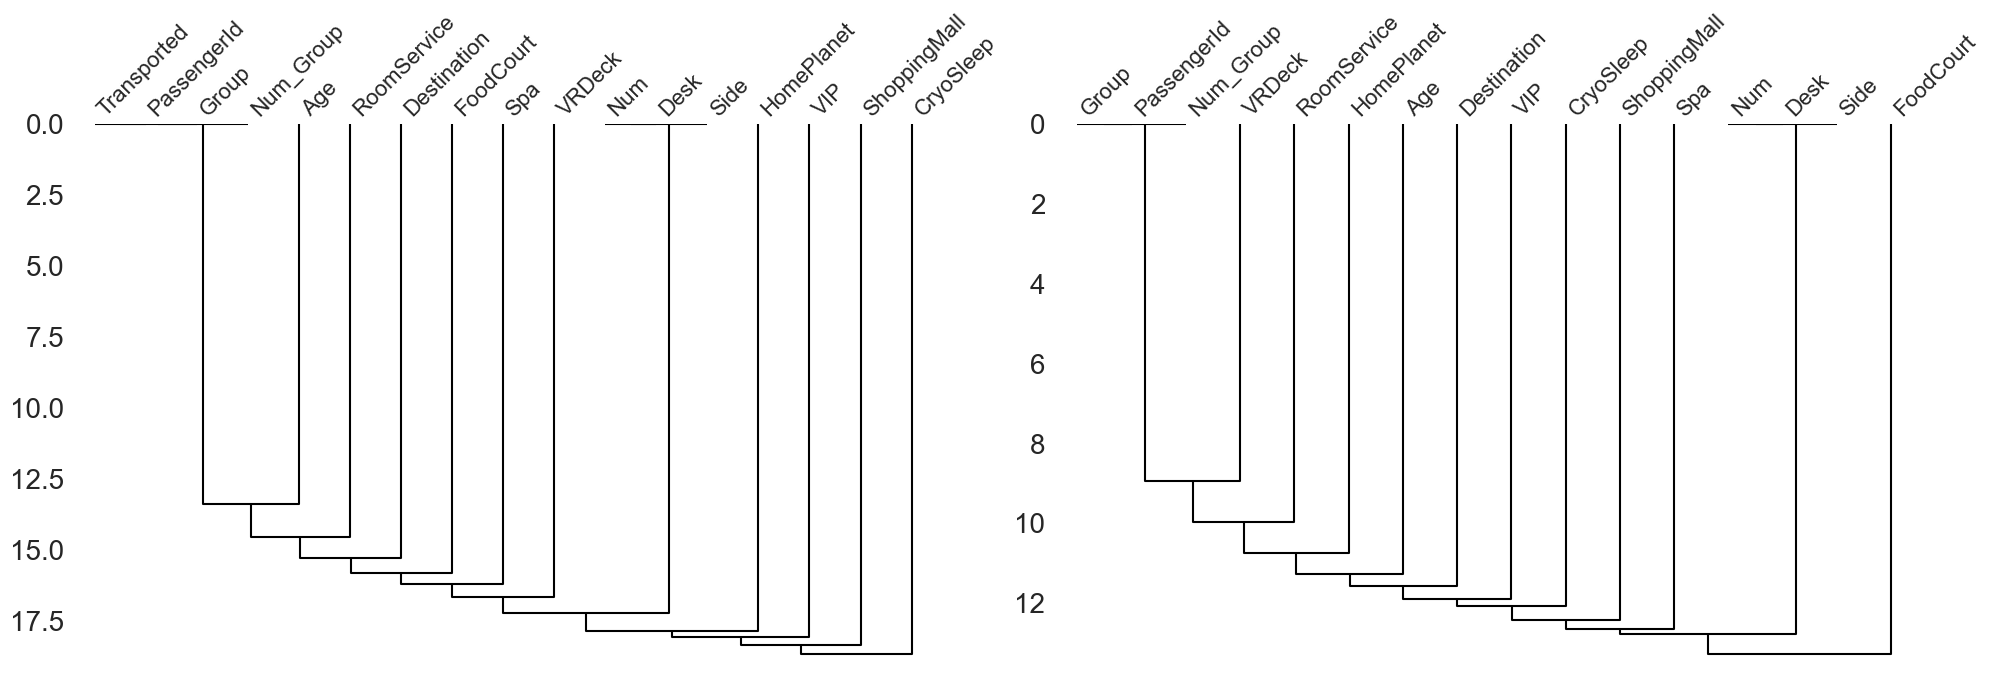

In [129]:
#Visualizar correlaciones de nulalidad entre las diferentes columnas.
fig, ax=plt.subplots(1,2,figsize=(20,7))
ms.dendrogram(Df_Spaces_train, ax=ax[0])
ms.dendrogram(Df_Spaces_test, ax=ax[1])

El siguiente cladograma muestra que no hay columnas que tenga nulalidad correlacionada. La nulalidad correlacionada son de la columnas separadas.

In [5]:
#separate variables into new data frames
numeric_data = Df_Spaces_train.select_dtypes(include=[np.number])
cat_data = Df_Spaces_train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 7 numeric and 10 categorical columns in train data


<AxesSubplot: >

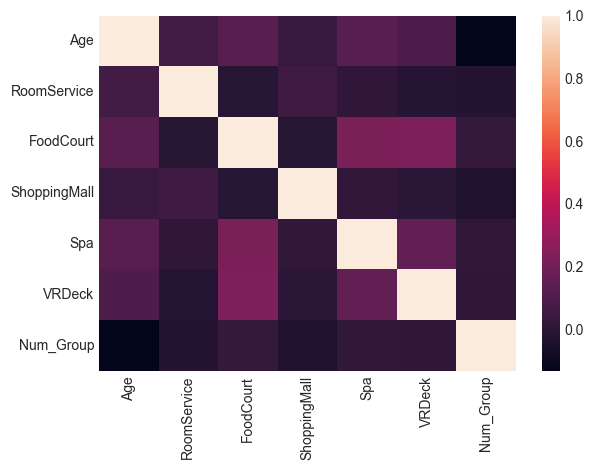

In [6]:
#correlation plot
corr = numeric_data.corr()
sns.heatmap(corr)

In [130]:
#Df_Spaces_train.isnull().sum() #Muestra el total de valores perdidos por columnas en el dataframa de entrenamiento
# PassengerId       0
# HomePlanet      201
# CryoSleep       217
# Destination     182
# Age             179
# VIP             203
# RoomService     181
# FoodCourt       183
# ShoppingMall    208
# Spa             183
# VRDeck          188
# Name            200
# Transported       0
# Group             0
# Num_Group         0
# Desk            199
# Num             199
# Side            199
# dtype: int64

In [131]:
#Df_Spaces_train.isnull().sum() #Muestra el total de valores perdidos por columnas en el dataframa de entrenamiento
# PassengerId       0
# HomePlanet      201
# CryoSleep       217
# Destination     182
# Age             179
# VIP             203
# RoomService     181
# FoodCourt       183
# ShoppingMall    208
# Spa             183
# VRDeck          188
# Name            200
# Transported       0
# Group             0
# Num_Group         0
# Desk            199
# Num             199
# Side            199
# dtype: int64

En las siguientes columnas se muestra la columnas y cantidad de valores perdidos para los diferentes dataframe entrenamiento y prueba.

<AxesSubplot: title={'center': 'Test'}, xlabel='Desk,HomePlanet'>

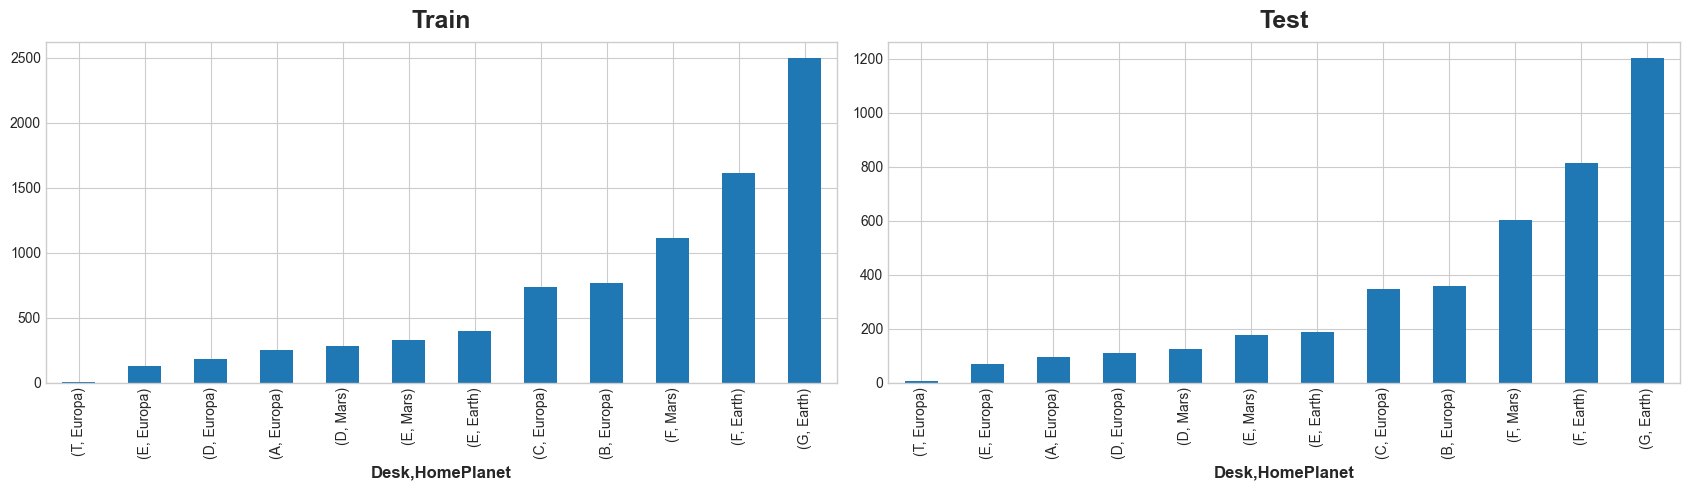

In [132]:
fig, ax=plt.subplots(1,2, figsize=(17,5))
#El siguente codigo cuenta cuantos Homeplanet hay por cada desk para el dataframe de entrenamiento
Df_Spaces_train.groupby(['Desk','HomePlanet'])['HomePlanet'].count().sort_values(ascending=True).plot(kind='bar', title='Train', ax=ax[0])
#El siguente codigo cuenta cuantos Homeplanet hay por cada desk para el dataframe de Test
Df_Spaces_test.groupby(['Desk','HomePlanet'])['HomePlanet'].count().sort_values(ascending=True).plot(kind='bar', title='Test',ax=ax[1])


En la grafíca anterior se puede observar que si la persona estan en Desk igual A , B, C y T la probabilidad que sea de Europa es mayor, comaparada con las demas Desk.

Tambien se puede observar que las personas que están en Desk igual G la probailidad que sea de Earth es mayor tanto para Train y Prueba

<AxesSubplot: title={'center': 'Test'}, xlabel='Desk,CryoSleep'>

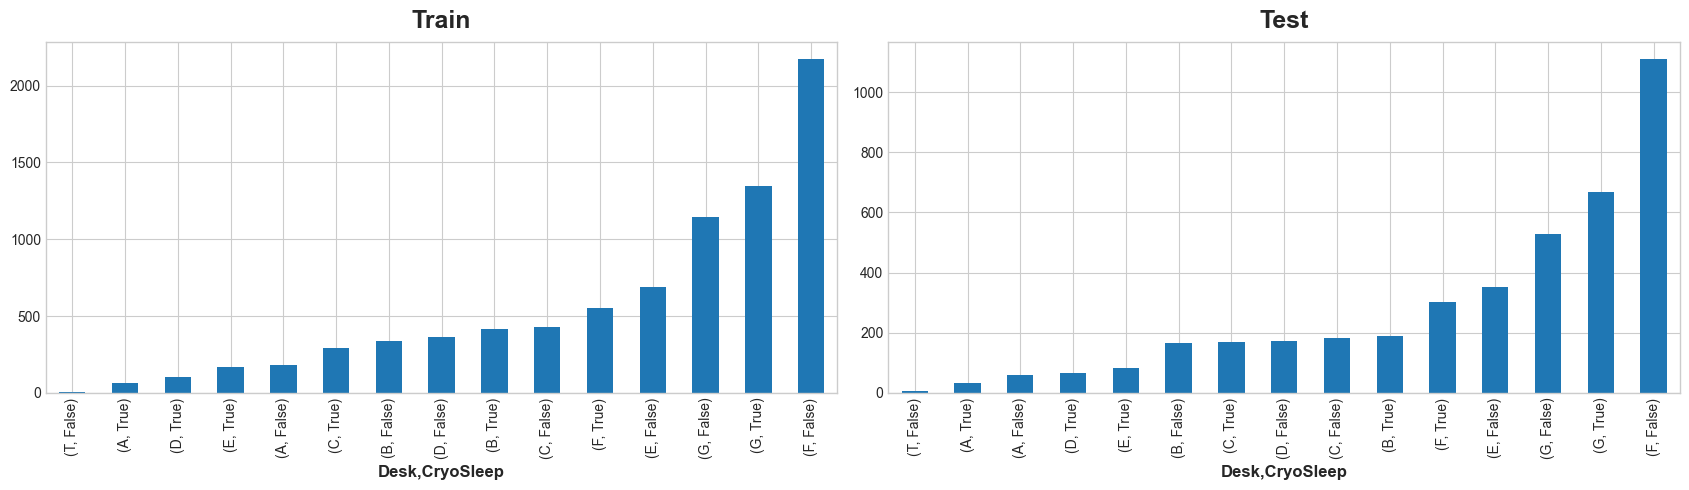

In [133]:
fig, ax=plt.subplots(1,2, figsize=(17,5))
#El siguente codigo cuenta cuantos Homeplanet hay por cada Num_Group para el dataframe de entrenamiento
Df_Spaces_train.groupby(['Desk','CryoSleep'])['CryoSleep'].count().sort_values(ascending=True).plot(kind='bar', title='Train', ax=ax[0])
#El siguente codigo cuenta cuantos Homeplanet hay por cada Num_Group para el dataframe de Test
Df_Spaces_test.groupby(['Desk','CryoSleep'])['CryoSleep'].count().sort_values(ascending=True).plot(kind='bar', title='Test',ax=ax[1])

- Desk igual a T se puede observar que la probabilidad que pertenezcan a CryoSleep False es mayor tanto para Train y Prueba

<AxesSubplot: title={'center': 'Test'}, xlabel='Num_Group,VIP'>

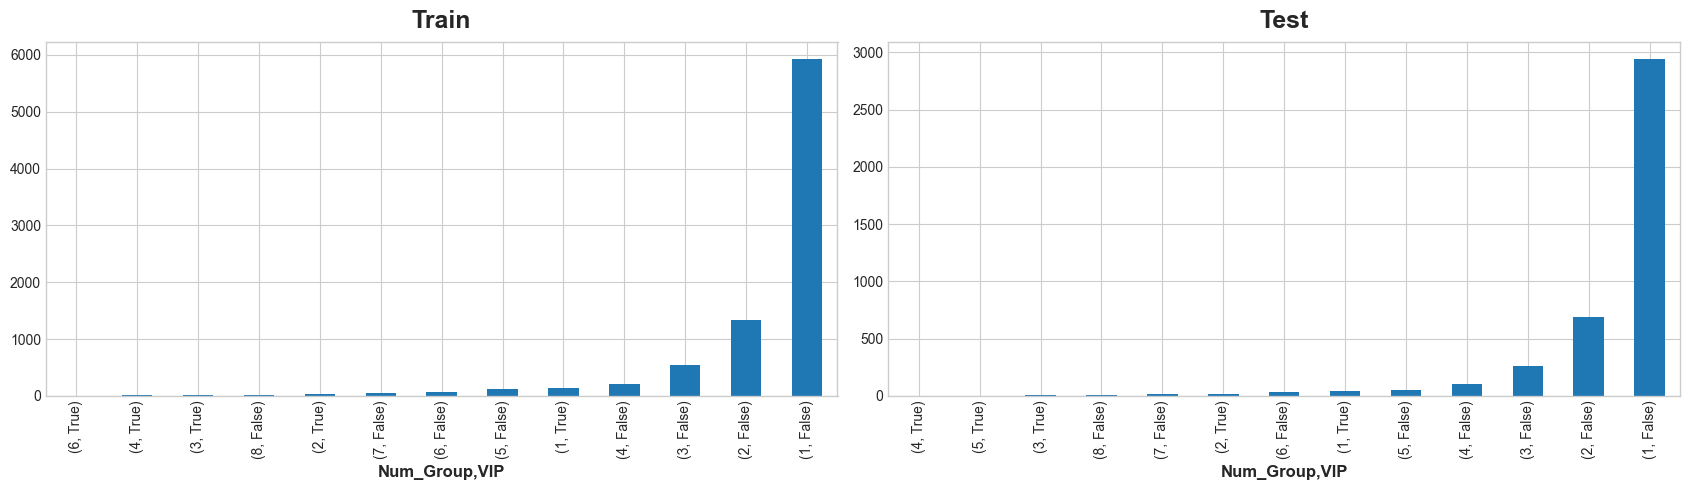

In [134]:
fig, ax=plt.subplots(1,2, figsize=(17,5))
#El siguente codigo cuenta cuantos VIP hay por cada Num_Group para el dataframe de entrenamiento
Df_Spaces_train.groupby(['Num_Group','VIP'])['VIP'].count().sort_values(ascending=True).plot(kind='bar', title='Train', ax=ax[0])
#El siguente codigo cuenta cuantos VIP hay por cada Num_Group para el dataframe de Test
Df_Spaces_test.groupby(['Num_Group','VIP'])['VIP'].count().sort_values(ascending=True).plot(kind='bar', title='Test',ax=ax[1])

- En las graficas se muestra que la mayor cantidad de personas que no eran VIP pertenecen al grupo 01
- Los grupos 07 y 08 se puede observar que la probabilidad que pertenezcan a VIP False es mayor tanto para Train y Prueba

<AxesSubplot: title={'center': 'Test'}, xlabel='Num_Group,HomePlanet'>

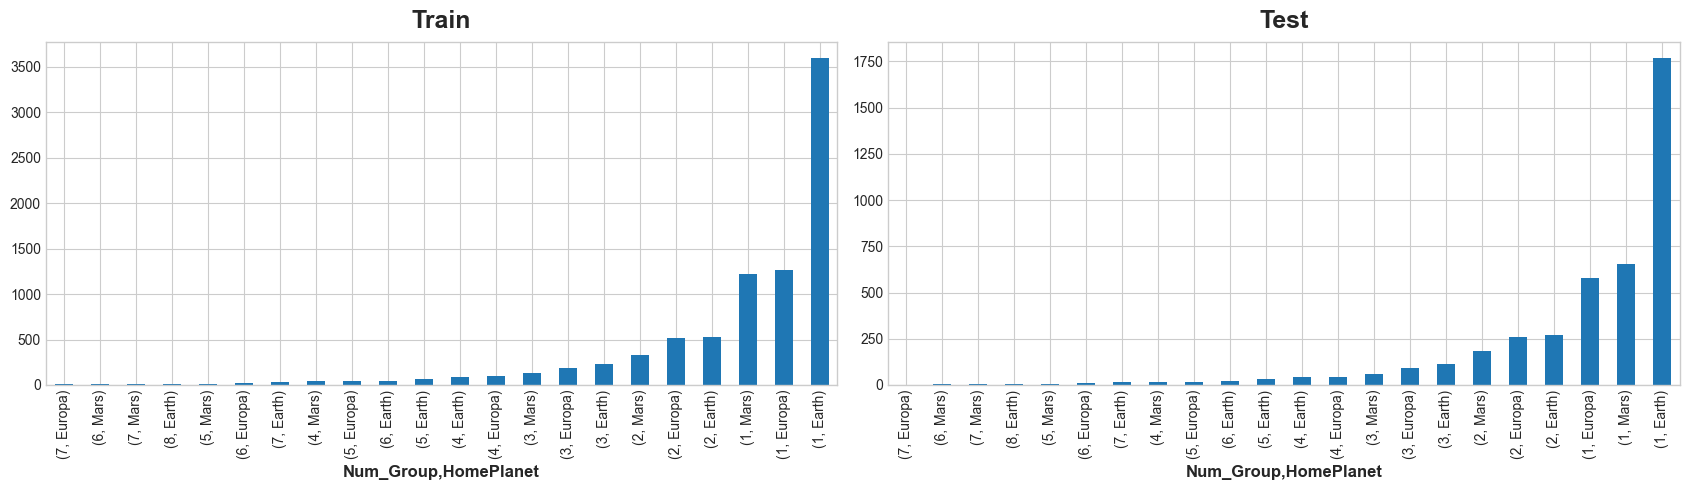

In [135]:
fig, ax=plt.subplots(1,2, figsize=(17,5))
#El siguente codigo cuenta cuantos Homeplanet hay por cada Num_Group para el dataframe de entrenamiento
Df_Spaces_train.groupby(['Num_Group','HomePlanet'])['HomePlanet'].count().sort_values(ascending=True).plot(kind='bar', title='Train', ax=ax[0])
#El siguente codigo cuenta cuantos Homeplanet hay por cada Num_Group para el dataframe de Test
Df_Spaces_test.groupby(['Num_Group','HomePlanet'])['HomePlanet'].count().sort_values(ascending=True).plot(kind='bar', title='Test',ax=ax[1])

- La mayoria de las personas que viajaban en el grupo 01 pertenecian Earth que representa la mayor población.
- Como se muestra en la graficas en el grupo 08, las personas tienen mayor probabilidad de pertenecer Earth tanto para Train y Prueba

<AxesSubplot: title={'center': 'Test'}, xlabel='Destination'>

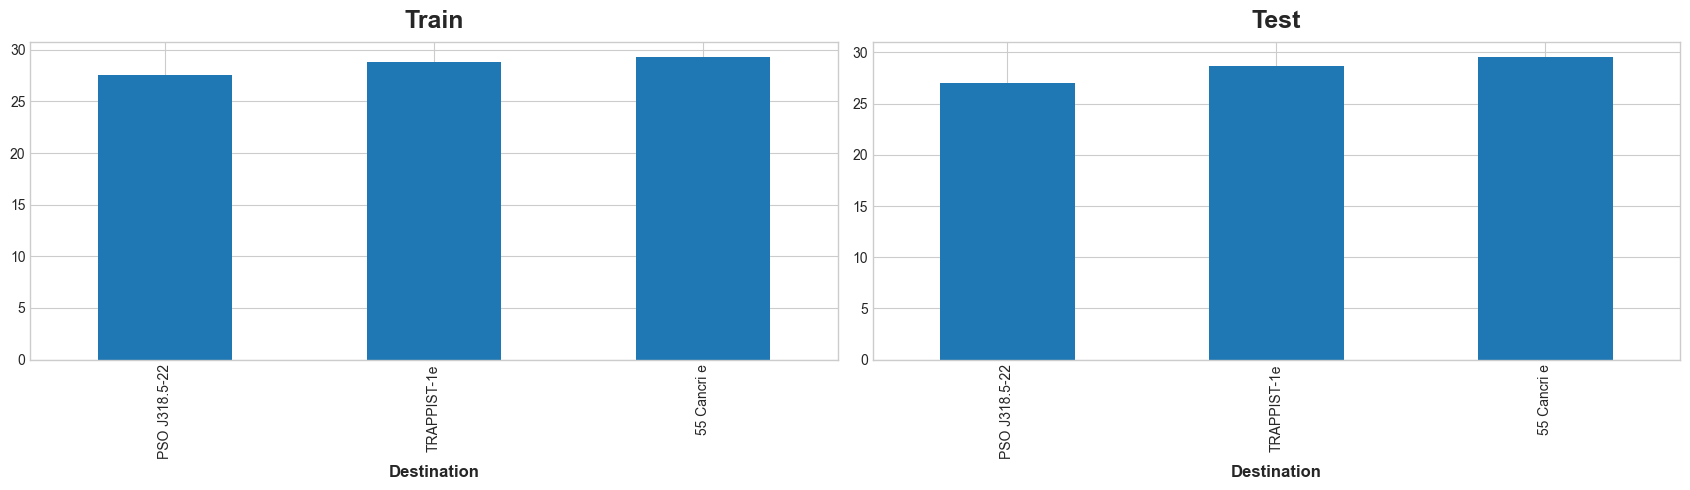

In [136]:
fig, ax=plt.subplots(1,2, figsize=(17,5))
#El siguente codigo cuenta cuantos Age hay por cada Num_Group para el dataframe de entrenamiento
Df_Spaces_train.groupby(['Destination'])['Age'].mean().sort_values(ascending=True).plot(kind='bar', title='Train', ax=ax[0])
#El siguente codigo cuenta cuantos Age hay por cada Num_Group para el dataframe de Test
Df_Spaces_test.groupby(['Destination'])['Age'].mean().sort_values(ascending=True).plot(kind='bar', title='Test',ax=ax[1])

En las grafícas se puede observar que las medias no están iguamente distribuidos dentro del Destination, las medias varian dentro de los grupos.


In [137]:
#Resumen de las estadisticas conjunto de train
display(Df_Spaces_train.describe())
#Resumen de las estadisticas conjunto de test
display(Df_Spaces_test.describe())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num_Group
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1.517773
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.054241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,2.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num_Group
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4277.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031,1.498714
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742,1.018221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000,2.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000,8.000000


En las siguientes resumen estadistico se puede observar que Age tiene una incosistencia en los datos, dado que tiene valores de Age como cero, Las desviación estandar refleja una alta variansa en los datos, encontrando medias muy diferentes entre las columnas.El 50% de los valores para las columnas RoomService, FoodCourt, ShoppingMall, Spa y VRDeck son cero.

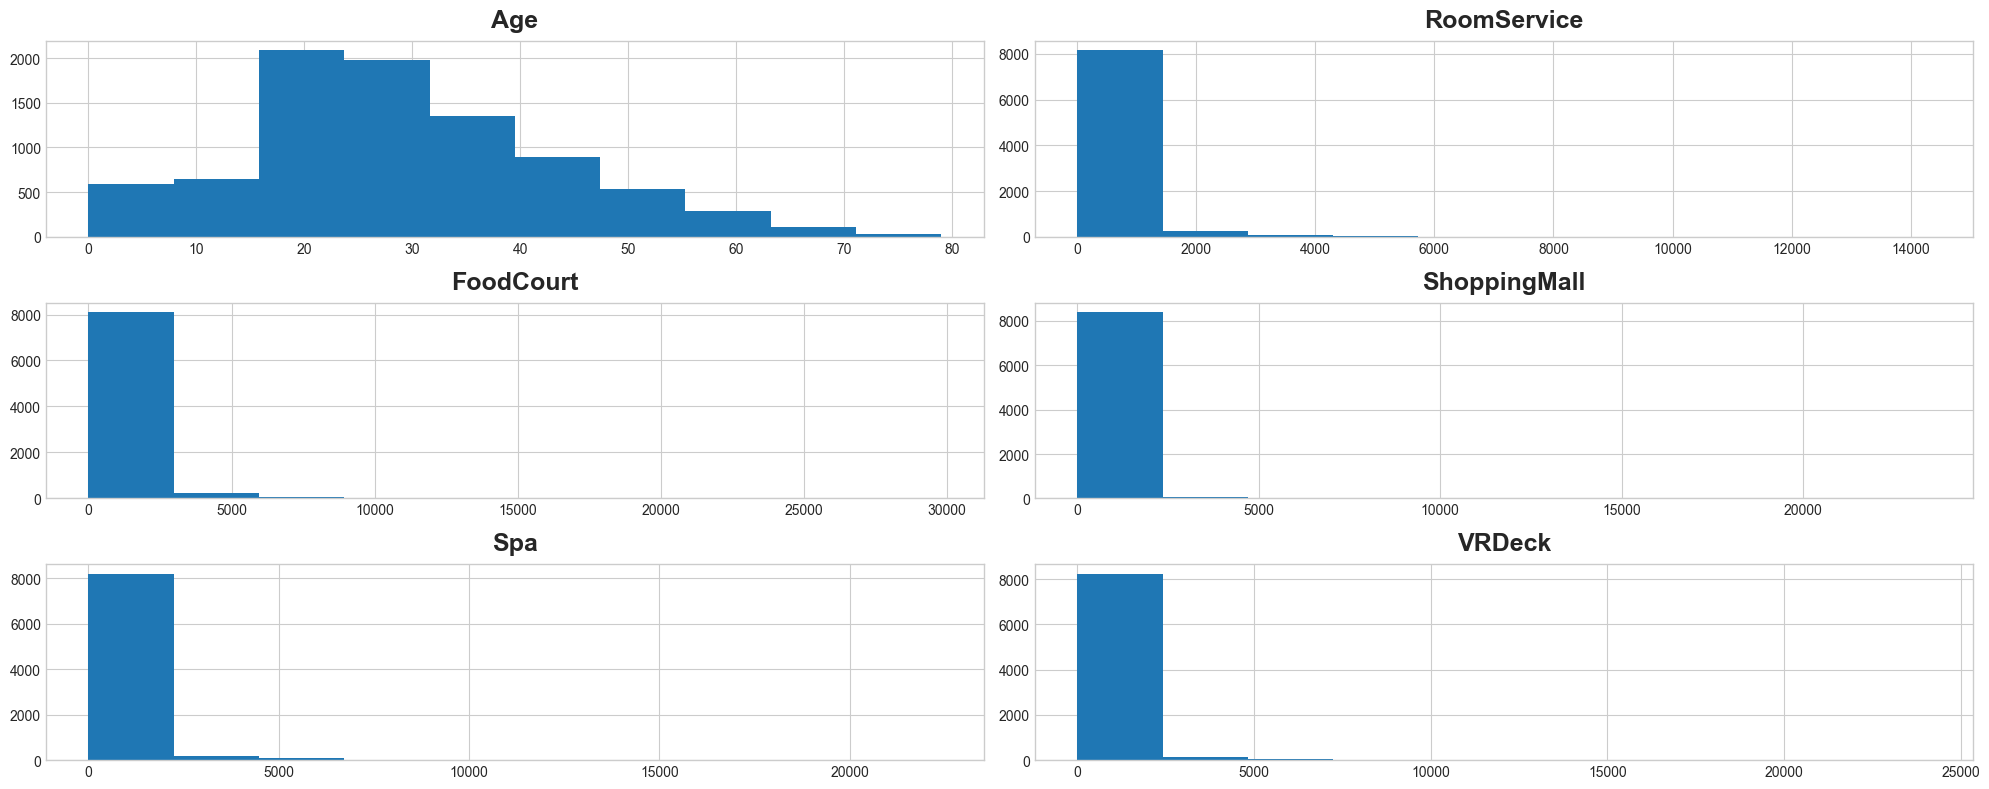

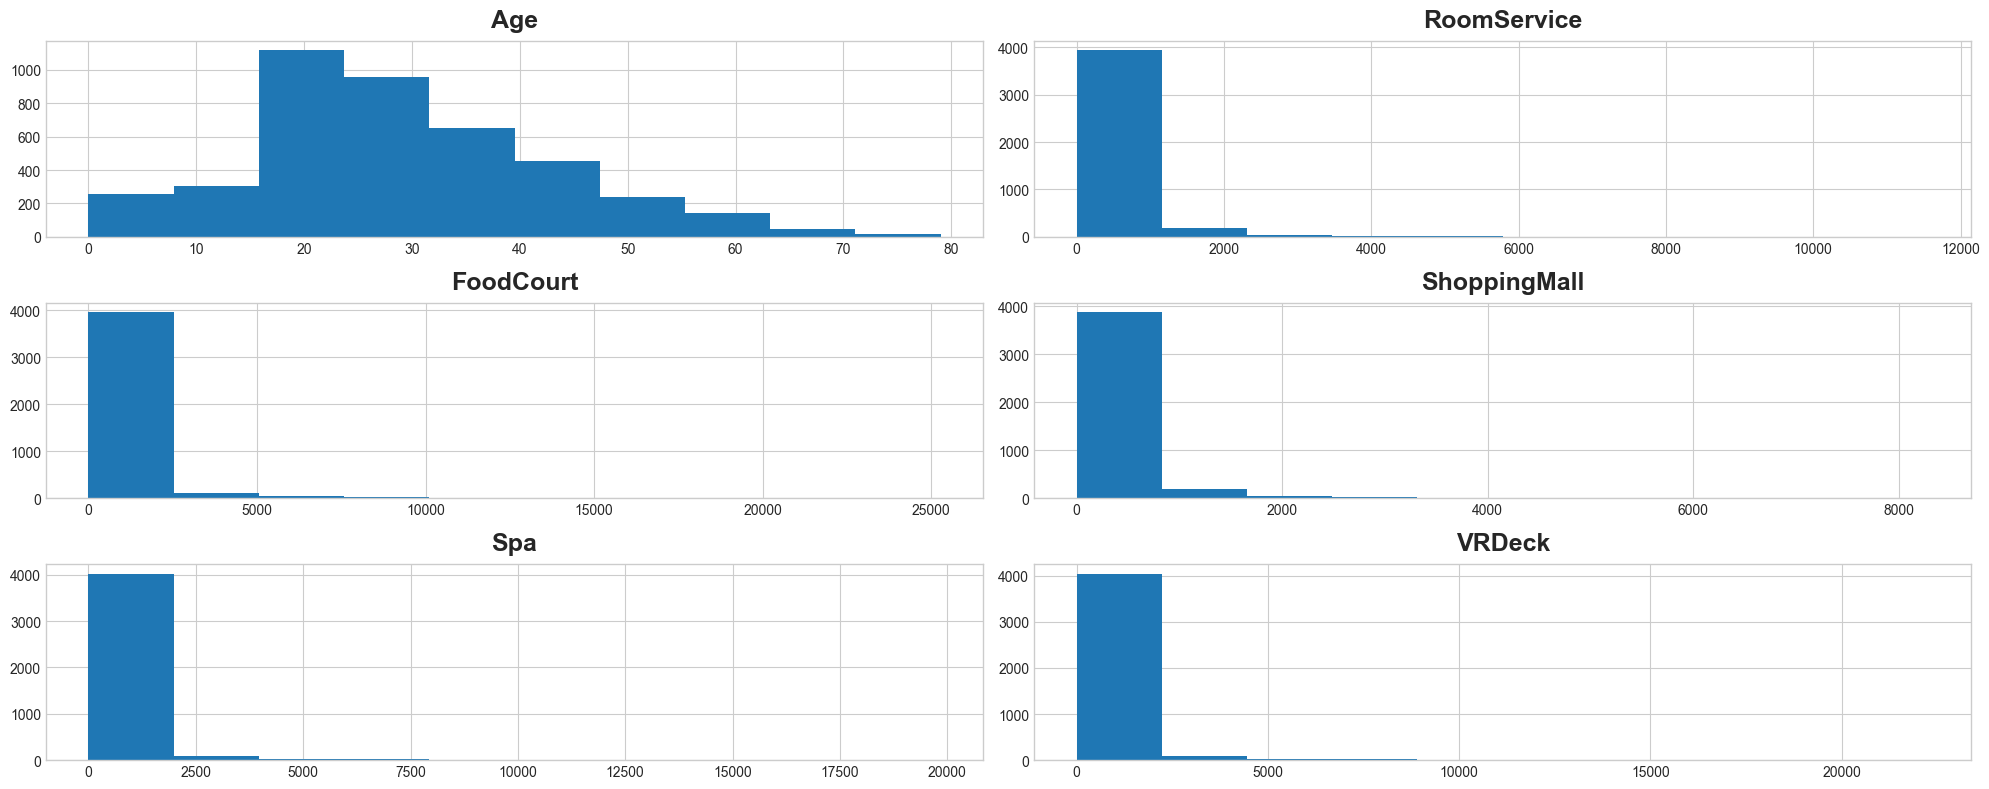

In [138]:
#Distribución de los siguientes columnas del Train
Df_Spaces_train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].hist()
plt.gcf().set_size_inches(20,8)
#Distribución de los siguientes columnas del Test
Df_Spaces_test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].hist()
plt.gcf().set_size_inches(20,8)



En las grafícas anteriores se pueden apreciar que todas exepto Age tiene una distribución similar, como es de esperarse dónde tienen el 50% de sus datos es cero para los conjuntos de datos tanto train y test.

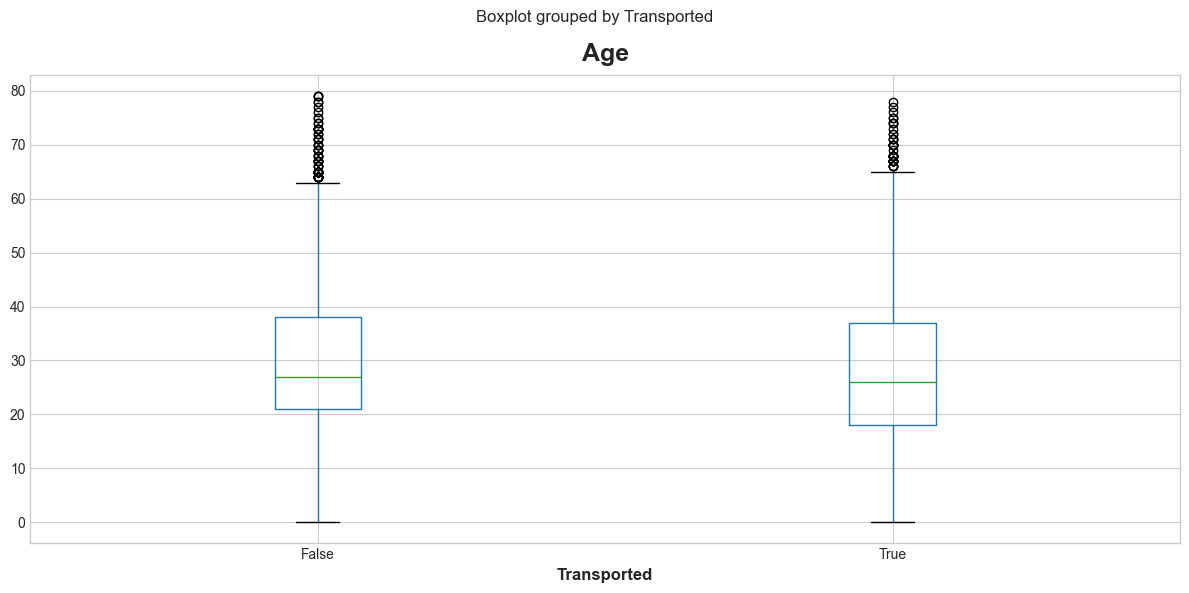

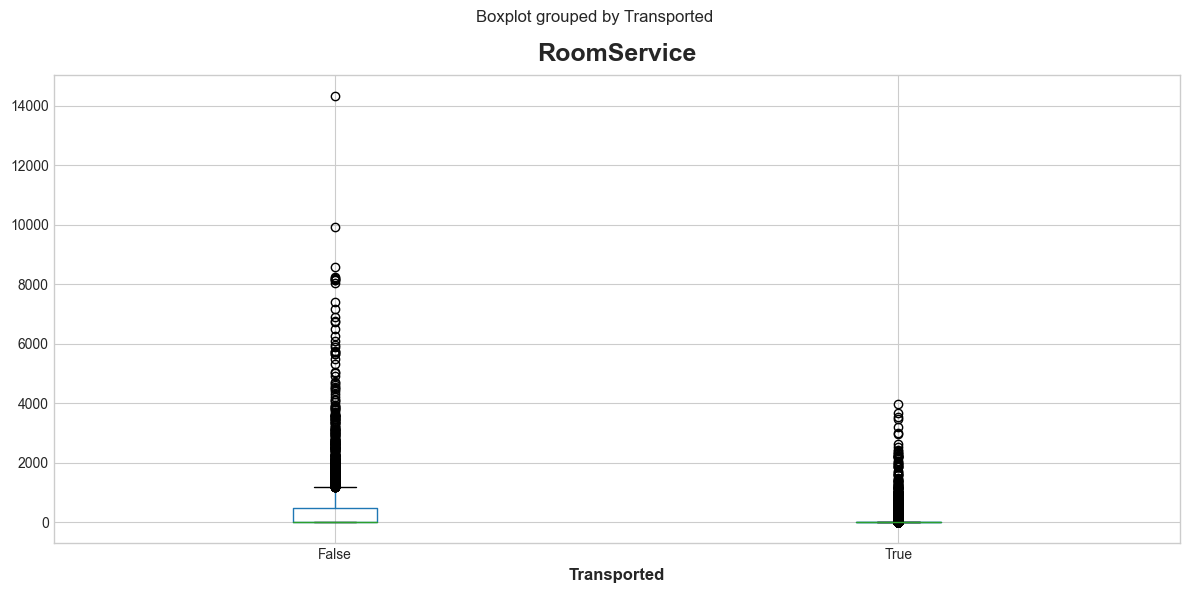

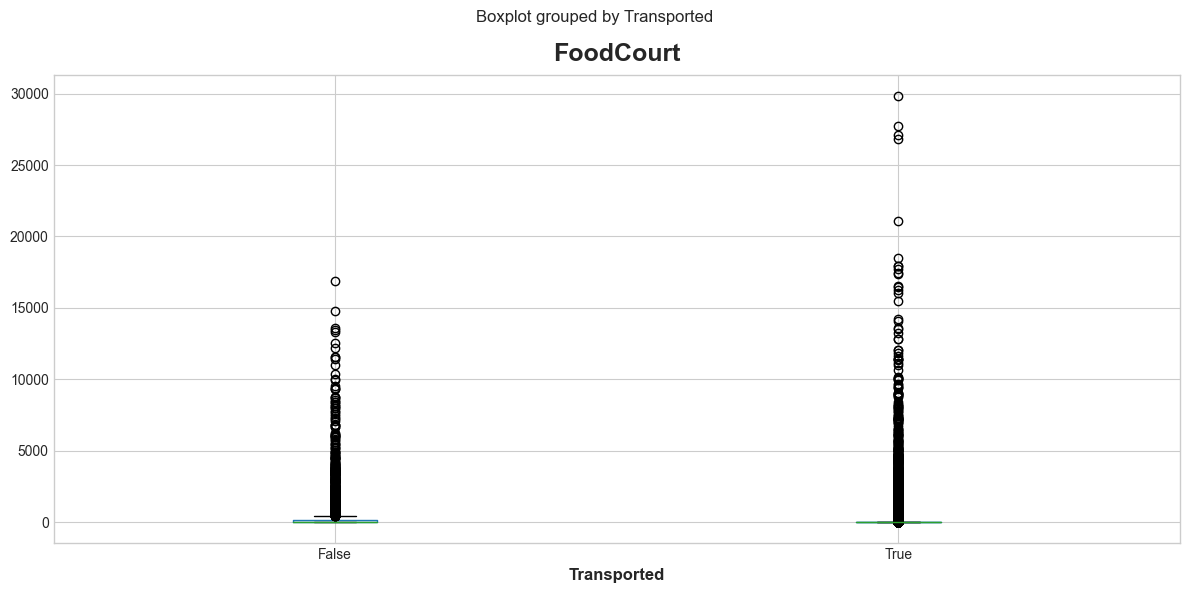

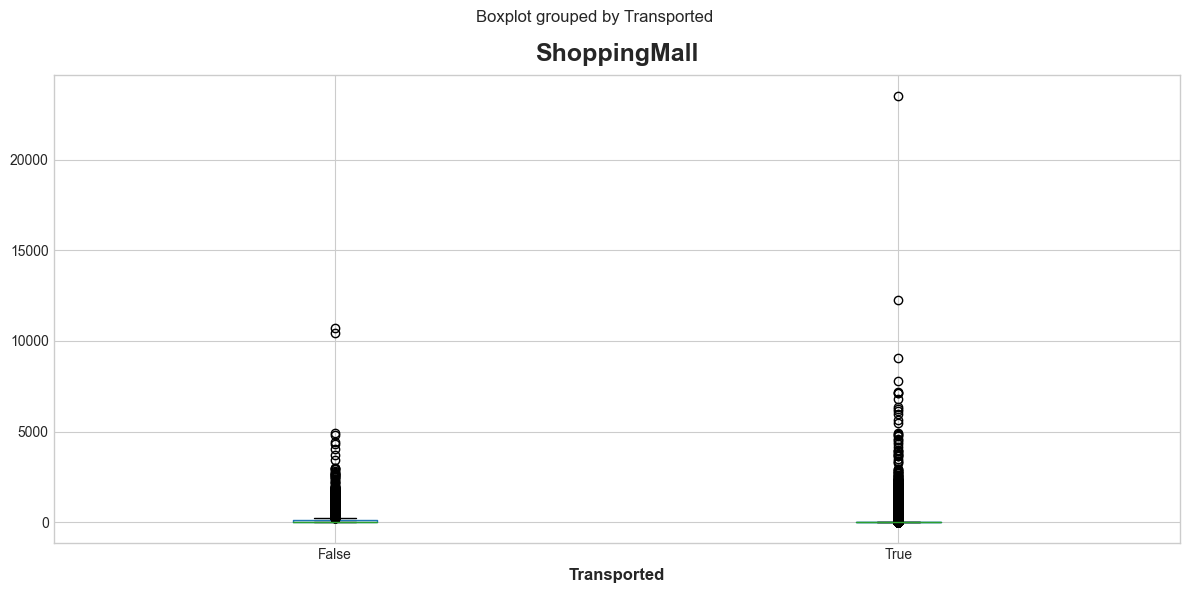

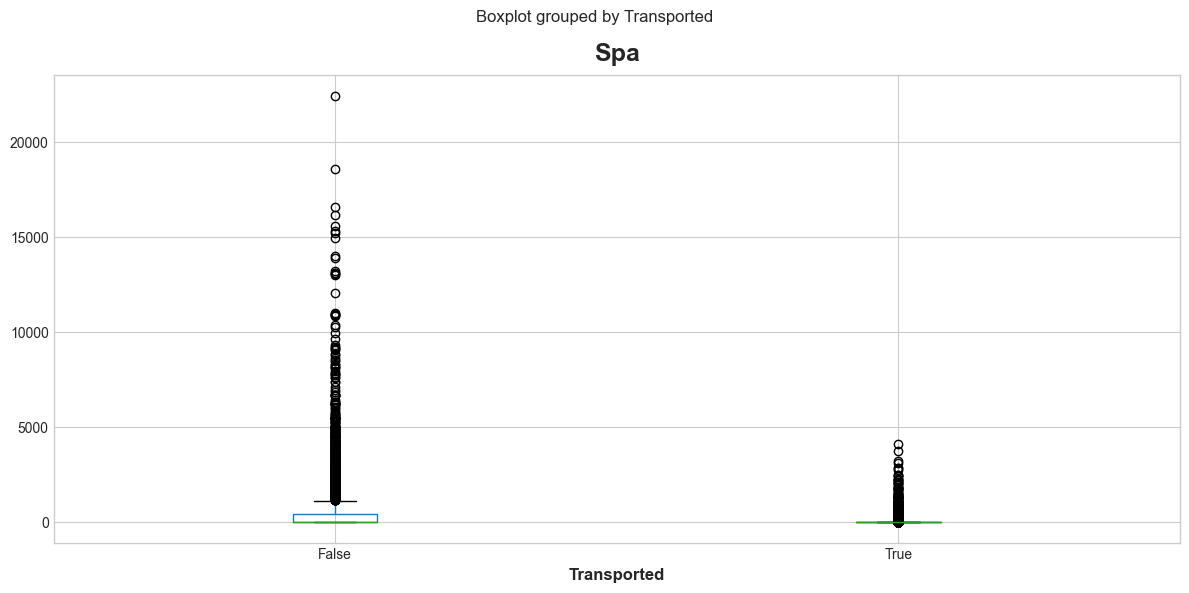

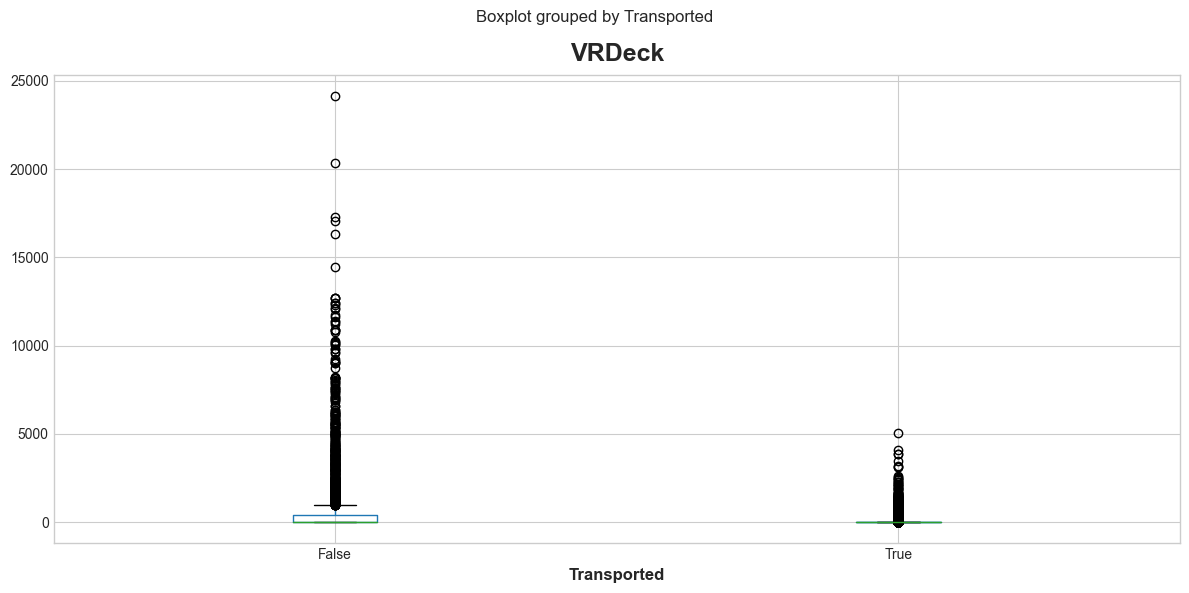

In [139]:
features = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in features:
    Df_Spaces_train.boxplot(column=col, by='Transported', figsize=(12,6))
    plt.title(col)
plt.show()

Para algunas de las características, hay una diferencia notable en la distribución para cada valor de etiqueta. En particular exepto **Age**, **ShoppingMall** y **FoodCourt**, El resto muestra distribuciones marcadamente diferentes para personas transportadas que para personas no transportadas. Estas características pueden ayudar a predecir si un persona es transportado o no.

<AxesSubplot: xlabel='Destination', ylabel='Transported'>

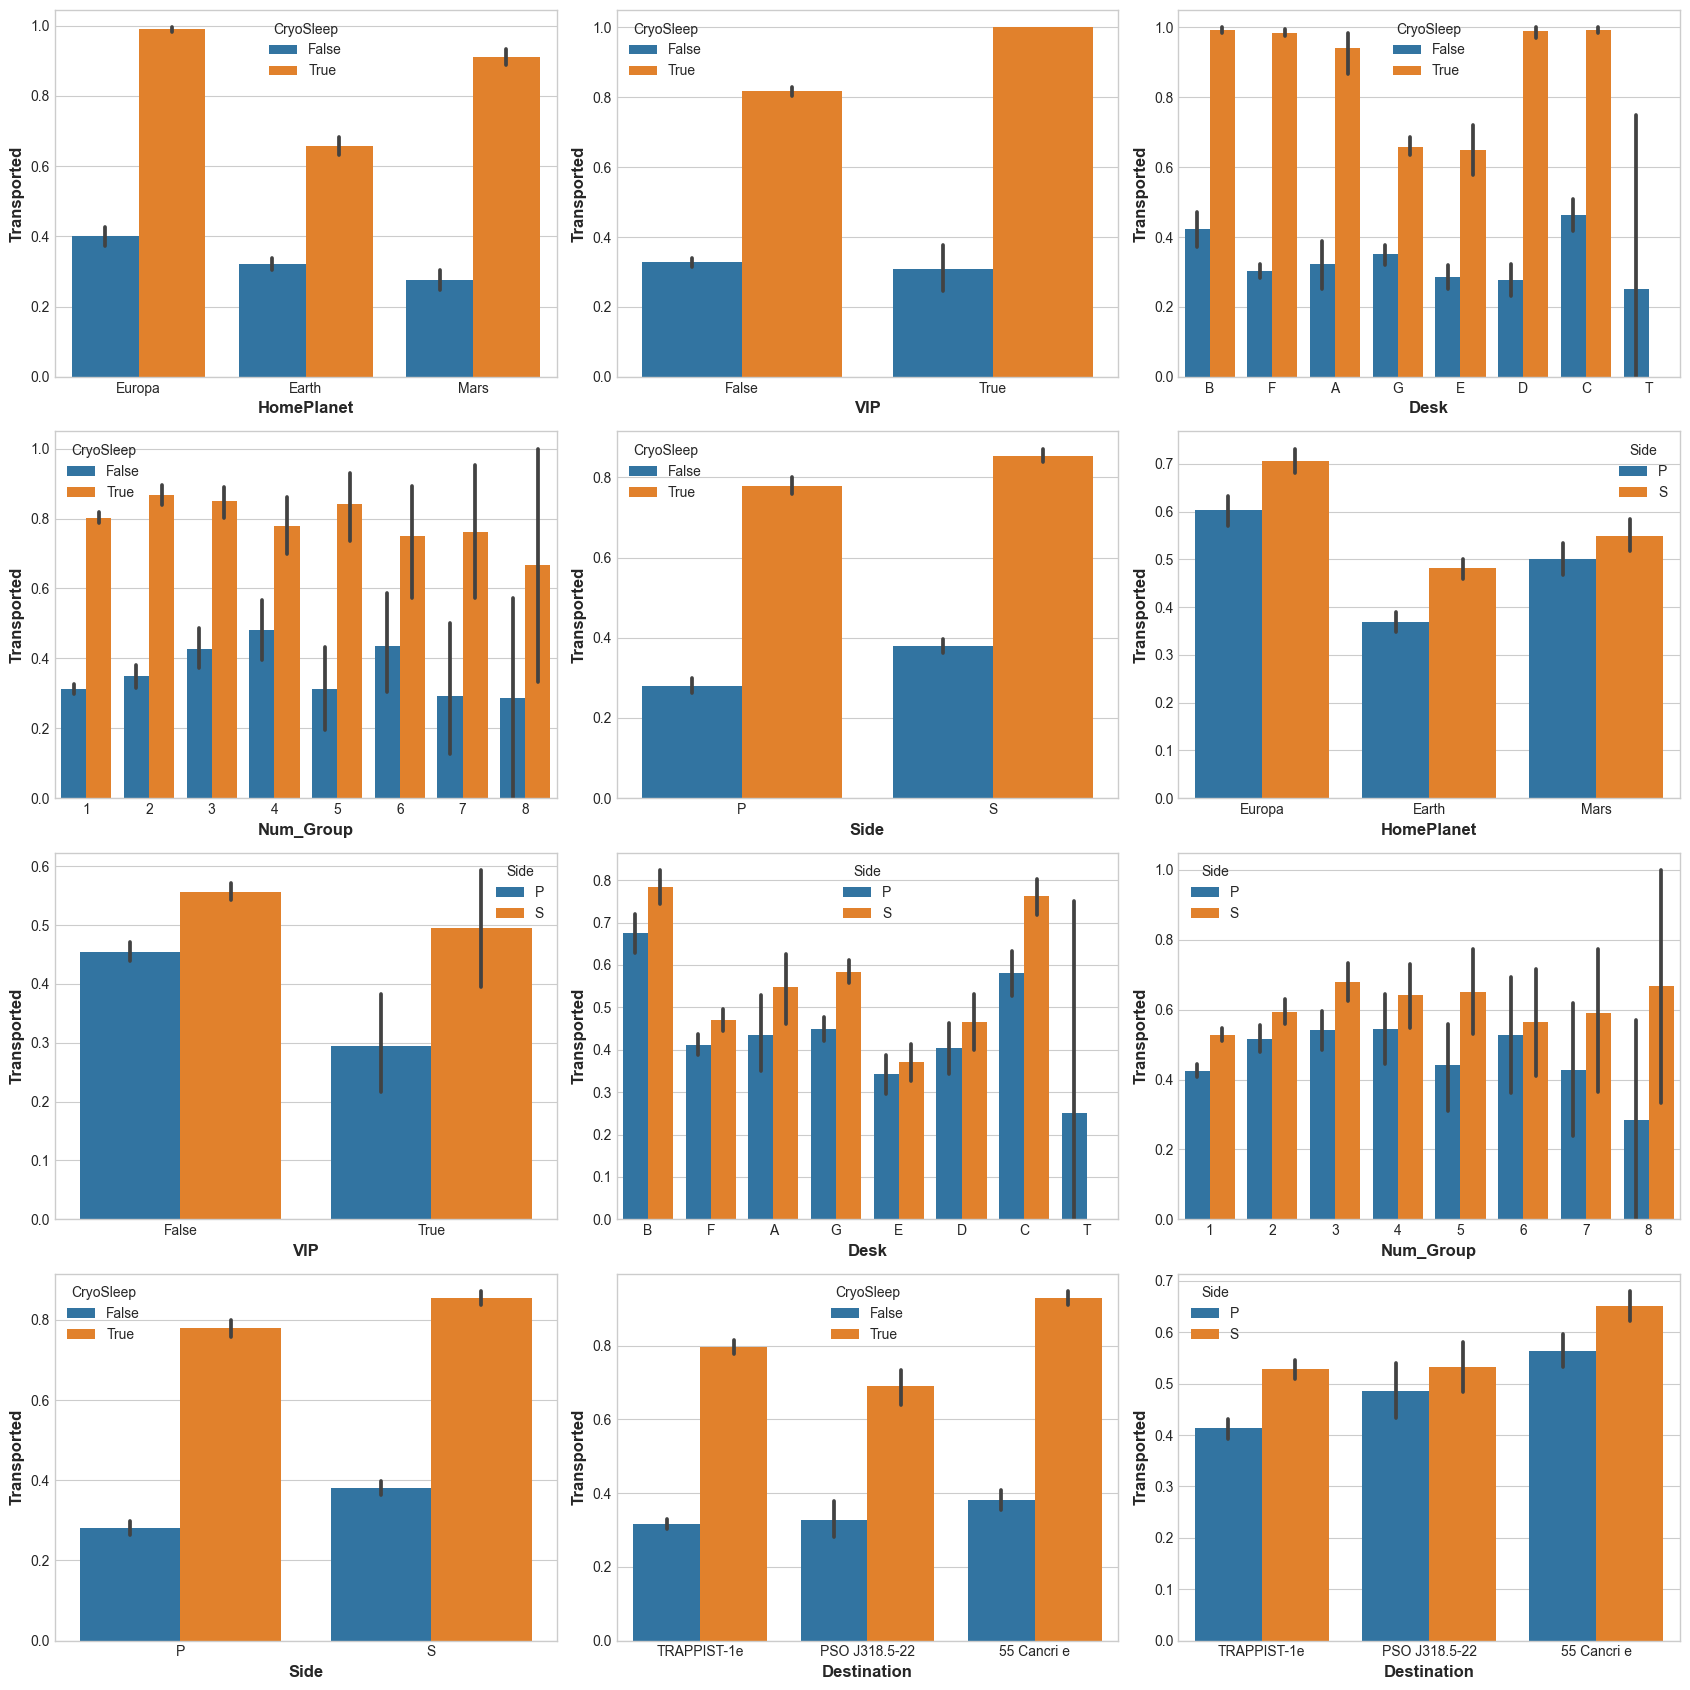

In [140]:
fig, ax = plt.subplots(4, 3, figsize=(17, 17))
sns.barplot(data=Df_Spaces_train, x='HomePlanet', y='Transported', hue='CryoSleep',ax=ax[0,0])
sns.barplot(data=Df_Spaces_train, x='VIP', y='Transported', hue='CryoSleep',ax=ax[0,1])
sns.barplot(data=Df_Spaces_train, x='Desk', y='Transported', hue='CryoSleep',ax=ax[0,2])
sns.barplot(data=Df_Spaces_train, x='Num_Group', y='Transported', hue='CryoSleep',ax=ax[1,0])
sns.barplot(data=Df_Spaces_train, x='Side', y='Transported', hue='CryoSleep',ax=ax[1,1])
sns.barplot(data=Df_Spaces_train, x='HomePlanet', y='Transported', hue='Side',ax=ax[1,2])
sns.barplot(data=Df_Spaces_train, x='VIP', y='Transported', hue='Side',ax=ax[2,0])
sns.barplot(data=Df_Spaces_train, x='Desk', y='Transported', hue='Side',ax=ax[2,1])
sns.barplot(data=Df_Spaces_train, x='Num_Group', y='Transported', hue='Side',ax=ax[2,2])
sns.barplot(data=Df_Spaces_train, x='Side', y='Transported', hue='CryoSleep',ax=ax[3,0])
sns.barplot(data=Df_Spaces_train, x='Destination', y='Transported', hue='CryoSleep',ax=ax[3,1])
sns.barplot(data=Df_Spaces_train, x='Destination', y='Transported', hue='Side',ax=ax[3,2])



En las grafícas anteriores se puede concluir:
1. Las personas que estabán en CryoSleep(True) la probailidad de Transportarse es mayor para los diferentes grupos.
2. Las personas que estabán en Side P la probailidad de sobrevivir es mayor para los diferentes grupos.
3. La tendencia muestra que las personas que fuerón puesta en Cryosleep muestra una tendencia mayor con el resto de los grupos.


# 2. Limpieza de datos

In [141]:
#Column Cabin
def Cambiar_Nulos_HomePlanet(df):
    """ Cambiar los nulos por un valores más probables"""
    
    df.loc[(((df['Desk']=='A') | (df['Desk']=='B') | (df['Desk']=='C') | (df['Desk']=='T')) & (df['HomePlanet'].isnull())), 'HomePlanet']='Europa'
    df.loc[((df['Desk']=='G') & (df['HomePlanet'].isnull())), 'HomePlanet']='Earth'
    df.loc[((df['Desk']=='T') & (df['CryoSleep'].isnull())), 'CryoSleep']=False
    df.loc[(((df['Num_Group']=='7') | (df['Num_Group']=='8')) & (df['VIP'].isnull())), 'VIP']='False'
    df.loc[(((df['Num_Group']=='8')) & (df['HomePlanet'].isnull())), 'HomePlanet']='Earth'
    df['CryoSleep'] = df['CryoSleep'].astype('object')
    

Cambiar_Nulos_HomePlanet(Df_Spaces_train)
Cambiar_Nulos_HomePlanet(Df_Spaces_test)

In [142]:
def LimpiezaVariables(df):
    """ Esta funcion reemplaza los valores faltantes por el criterio más adecuado """
    
    #Remplar los valores ceros en edad por Valores perdidos
    df.Age.replace(0,np.nan, inplace=True)
    #Columnas númericas 
     #Llenar los valores perdidos de la edad utilizando la mediana por sexo
     
    # Se Reemplazan los valores faltantes en las columnas númericas 
    df['Age']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['Age']])
    df['RoomService']=SimpleImputer(missing_values=np.nan,strategy='median').fit_transform(df[['RoomService']])
    df['FoodCourt']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['FoodCourt']])
    df['ShoppingMall']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['ShoppingMall']])
    df['VRDeck']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['VRDeck']])
    df['Spa']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['Spa']])

    # Columnas Categorícas 
    df["Desk"]=df["Desk"].replace("np.nan",np.nan)

    df['HomePlanet']=df.groupby('Num_Group', group_keys=False)['HomePlanet'].apply(lambda x: x.fillna(x.mode()[0]))
    df['CryoSleep']=df.groupby('Num_Group', group_keys=False)['CryoSleep'].apply(lambda x: x.fillna(x.mode()[0]))
    df['VIP']=SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df[['VIP']])
    df['Destination']=df.groupby('Num_Group', group_keys=False)['Destination'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Side']=df.groupby('CryoSleep', group_keys=False)['Side'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Desk']=df.groupby('Num_Group', group_keys=False)['Desk'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Num']=SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df[['Num']])
    

LimpiezaVariables(Df_Spaces_train)
LimpiezaVariables(Df_Spaces_test)

# 2. Ingeniería de características

In [143]:
def Ifeatures(df):
    df['Total']=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    # Total passengers by Deck


# 

Ifeatures(Df_Spaces_train)
Ifeatures(Df_Spaces_test)


# 3. Preprosamiento

In [144]:
def preprosamiento(df):
    df.set_index('PassengerId', inplace=True)
preprosamiento(Df_Spaces_test)
preprosamiento(Df_Spaces_train)

In [145]:

X = Df_Spaces_train.copy() # Se hace una copia al dataset

y=X.Transported

X.drop('Transported', axis=1, inplace=True)
#Columnas númerica
columnas_numericas=[num for num in X.columns if X[num].dtype in ['int64', 'float64']]

#Columnas categorícas 
columnas_categoricas=[num for num in X.columns if X[num].dtype=='object' or X[num].dtype=='bool']

# Columnas que no tienen problema en el One Hot
cols_good = [col for col in columnas_categoricas if X[col].nunique()<=10]

# Columns that will be dropped from the dataset
cols_bad = list(set(columnas_categoricas)-set(cols_good))


X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.3, random_state=2)

print('Categorical columns that will be one-hot encoded:', cols_good)
print('\nCategorical columns that will be dropped from the dataset:', cols_bad)

Categorical columns that will be one-hot encoded: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Desk', 'Side']

Categorical columns that will be dropped from the dataset: ['Group', 'Num']


In [146]:
#### One-hot encoding

#### One-hot encoding
X_train_hot = X_train.copy()
X_valid_hot = X_valid.copy()
encoder = OneHotEncoder(sparse_output=False) # armamos el encoder. sparse=False nos devuelve una matriz comun a la que estamos acostumbrados (en vez de esparsa)

encoder.fit_transform(X_train_hot[cols_good]) # fiteo reshapeando el vector y_train como veníamos haciendo pues no tiene formato de matriz
encoder.fit_transform(X_valid_hot[cols_good]) 


X_train_cater=pd.DataFrame(encoder.transform(X_train[cols_good])) # obtenemos la mariz binaria
X_valid_cater=pd.DataFrame(encoder.transform(X_valid[cols_good]))# obtenemos la mariz binaria

X_train_cater.index=X_train_hot.index
X_valid_cater.index=X_valid_hot.index


X_train_OneHot=pd.concat([X_train_cater,X_train[columnas_numericas]], axis=1) #Concatenamos las columnas númericas y categorícas
X_valid_OneHot=pd.concat([X_valid_cater,X_valid[columnas_numericas]], axis=1)

X_train_OneHot.columns = X_train_OneHot.columns.astype(str)
X_valid_OneHot.columns = X_valid_OneHot.columns.astype(str)

#Normalización 

#Creación del objeto 
scaler=MinMaxScaler()

#Train
scaler.fit(X_train_OneHot) #Buscar el valor adecuado 
X_train_OneHot=pd.DataFrame(scaler.transform(X_train_OneHot))

#Test
scaler.fit(X_valid_OneHot) #Buscar el valor adecuado 
X_valid_OneHot=pd.DataFrame(scaler.transform(X_valid_OneHot))

X_train_OneHot.columns = X_train_OneHot.columns.astype(str)
X_valid_OneHot.columns = X_valid_OneHot.columns.astype(str)


#### Mutual Informacion

In [147]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train_OneHot, y_train)

# Imprimir la información mutua para cada característica
features=[]
for i, mi in enumerate(mutual_info):
    if mi>=0.05:
      features.append(str(i))
      print(f"Característica {i}: {mi:.5f}")

Característica 3: 0.10281
Característica 4: 0.10097
Característica 21: 0.07155
Característica 24: 0.08218
Característica 25: 0.06303
Característica 27: 0.13380


#### Selección univariante utilizando la prueba F

In [148]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.feature_selection import f_regression
# from sklearn.feature_selection import mutual_info_classif
# # X es la matriz de características y y es el vector objetivo
# selector = SelectKBest(score_func=mutual_info_classif, k=10)
# X_new = selector.fit_transform(X_OneHot, y)
# # Imprimir las características seleccionadas
# print(selector.feature_names_in_[selector.get_support()])

#### Selección basada en modelos utilizando regresión logística:

In [149]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LogisticRegression

# # X es la matriz de características y y es el vector objetivo
# selector = SelectFromModel(estimator=LogisticRegression(solver='lbfgs', max_iter=1000),max_features=10)
# X_new = selector.fit_transform(X_OneHot, y)
# print(selector.feature_names_in_[selector.get_support()])

#### Selección de características con regularización utilizando Lasso:

In [150]:

# from sklearn.linear_model import Lasso

# # X es la matriz de características y y es el vector objetivo
# lasso = Lasso(alpha=0.1)
# lasso.fit(X_OneHot, y)
# selected_features = lasso.coef_ != 0
# X_new = X_OneHot[:, selected_features]


#### Métodos de filtro utilizando la correlación de Pearson:

In [151]:
# import numpy as np

# # X es la matriz de características y y es el vector objetivo
# corr_matrix = np.corrcoef(X_OneHot.values.T)
# corr_with_target = corr_matrix[-1, :-1]
# selected_features = abs(corr_with_target) > 0.5
# X_new = X_OneHot.selected_features


#### Métodos de envoltura utilizando la selección hacia adelante:

In [152]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.linear_model import LogisticRegression

# # X es la matriz de características y y es el vector objetivo
# selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=10, direction='forward')
# X_new = selector.fit_transform(X_OneHot, y)
# print(selector.feature_names_in_[selector.get_support()])



# Modelos 

## Modelo de arboles de Desiciones 

In [153]:

    
model_rf = RandomForestClassifier(n_estimators=213,
                                max_depth=10,
                                random_state=2, 
                                criterion="gini", 
                                #max_features=5,
                                min_samples_split=24,
                                class_weight='balanced'
                                
                                )
train_accuracy, test_accuracy = fit_and_test_model(model_rf,X_train_OneHot,X_valid_OneHot, y_train, y_valid)

print('Con OneHotEncoder')
print("Model trained!")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)


Con OneHotEncoder
Model trained!
Train accuracy 0.8356608628052904
Test accuracy 0.8106724371430254


## Modelo aumento del gradiente 

In [154]:
features=['18','19','20','21','22','23','25','1']
X_train_xgb=X_train_OneHot
X_valid_xgb=X_valid_OneHot
model=XGBClassifier(subsample=0.4, n_estimators=246, max_depth=13, learning_rate=0.01, gamma=1, colsample_bytree=0.5)

model.fit(X_train_xgb, y_train, 
             eval_set=[(X_valid_xgb, y_valid)],
             verbose=False)
predictions = model.predict(X_train_xgb)
train_accuracy = balanced_accuracy_score(y_train, predictions)

    # -- Test
predictions = model.predict(X_valid_xgb)
test_accuracy = balanced_accuracy_score(y_valid, predictions)

print("Model trained!")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)


Model trained!
Train accuracy 0.8624510025067531
Test accuracy 0.8140057704763587


## KNN

In [155]:
features=['19', '20', '21', '22', '23', '25']
X_train_knn=X_train_OneHot[features]
X_valid_knn=X_valid_OneHot[features]
clf = KNeighborsClassifier(n_neighbors=9, p=1, weights="distance") # clasificador
clf.fit(X_train_knn, y_train) # una sola vez

y_pred = clf.predict(X_valid_knn) # predigo etiquetas
accuracy =  balanced_accuracy_score(y_pred,y_valid) # acuraccy

print('Accuracy promedio:', accuracy) # el promedio

Accuracy promedio: 0.7272977913781284


In [156]:
#### One-hot encoding

#### One-hot encoding
X_test = Df_Spaces_test.copy()
encoder = OneHotEncoder(sparse_output=False) # armamos el encoder. sparse=False nos devuelve una matriz comun a la que estamos acostumbrados (en vez de esparsa)


encoder.fit(X_test[cols_good]) 



X_test_cater=pd.DataFrame(encoder.transform(X_test[cols_good]))# obtenemos la mariz binaria


X_test_cater.index=X_test.index


X_test=pd.concat([X_test_cater,X_test[columnas_numericas]], axis=1)


X_test.columns = X_test.columns.astype(str)

#Normalización 

#Creación del objeto 
scaler=MinMaxScaler()

#Train
scaler.fit(X_test) #Buscar el valor adecuado 
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.columns = X_test.columns.astype(str)
X_test.index=Df_Spaces_test.index

In [157]:
preds_test=model.predict(X_test)
preds_test = [True if i == 1 else False for i in preds_test]

In [158]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Transported': preds_test})
output.to_csv('submission.csv', index=False)

In [159]:
# Prepare the model 
rf=SVC(kernel='linear',C=0.5, gamma=0.3, class_weight='balanced') 
    
    # Train and test the result
train_accuracy, test_accuracy = fit_and_test_model(rf,X_train_OneHot,X_valid_OneHot, y_train, y_valid)
print("Model trained!")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

Model trained!
Train accuracy 0.7466033950277187
Test accuracy 0.7629747394453277


In [160]:
print('Modelo de Bosque aleatorio')
matrix_confusion(model_rf,X_train_OneHot, X_valid_OneHot, y_train, y_valid)
print('Modelo de aumento del gradiente')
matrix_confusion_Xgboost(model,X_train_xgb, X_valid_xgb, y_train, y_valid)
print('KNN')
matrix_confusion(clf,X_train_knn, X_valid_knn, y_train, y_valid)

Modelo de Bosque aleatorio


Modelo de aumento del gradiente


KNN
